In [1]:
# ==============================================================
# CELL 0 — Force HuggingFace to bypass xet-core's virtual FS
# ==============================================================

import os

# Force all HF model/cache writes into a real directory, not the xet-core VFS
os.environ["HF_HOME"] = "/tmp/hf"
os.environ["HF_DATASETS_CACHE"] = "/tmp/hf"
os.environ["TRANSFORMERS_CACHE"] = "/tmp/hf"

# Disable all progress bars so xet-core never receives progress callbacks
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

# Ensure the directory exists
os.makedirs("/tmp/hf", exist_ok=True)

print("HuggingFace cache redirected to /tmp/hf")
print("Progress bars disabled (bypassing xet-core).")


HuggingFace cache redirected to /tmp/hf
Progress bars disabled (bypassing xet-core).


In [5]:
# ==============================================================
# CELL 1 — Clean abstracts → TF–IDF → Embeddings → Clustering → Keywords → LLM Labels
# ==============================================================

from __future__ import annotations

import os
import re
import pickle
from pathlib import Path
from typing import Iterable, List, Dict

import numpy as np
import pandas as pd

import torch
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from transformers import pipeline


# --------------------------------------------------------------
# Environment + deterministic seed
# --------------------------------------------------------------

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
hf_device = 0 if device == "cuda" else -1

print(f"Using device: {device}")

DATA_PATH = Path("../data/dimensions/api/raw/combined/202511/df_dimensions.xlsx")
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)


# ==============================================================
# 0. LOAD RAW DATA AND CLEAN
# ==============================================================

print("=== LOADING RAW DATA ===")
df = pd.read_excel(DATA_PATH, index_col=0)

def clean_abstract(text: str) -> str:
    """Lowercase → remove non-alphanumerics → compress whitespace."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

print("Cleaning abstracts...")
df["abstract_clean"] = df["abstract"].astype(str).apply(clean_abstract)

df.to_pickle(MODELS_DIR / "df_clean.pkl")
print(f"Saved cleaned dataframe → {MODELS_DIR/'df_clean.pkl'}")

abstracts: List[str] = df["abstract_clean"].tolist()
print(f"Number of cleaned abstracts: {len(abstracts)}")


# ==============================================================
# 1. BIOMEDICAL VOCABULARY FILTERING
# ==============================================================

biomed_whitelist = {
    "bmi","hdl","ldl","egfr","ckd","af","cvd","t2d","cad","copd","gwas",
    "apoe","brca1","brca2","il6","tnf","vitamin","alzheimer","dementia",
    "osteoporosis","psoriasis","frailty","obesity","sleep","diabetes","tinnitus",
}

_banned_tokens = {
    # generic rubbish / abbreviations
    "ns","ac","re","ci","ip","pa","pm","oa","ra","mod","ask","agin",
    "inf","gwa","nan","sup","cov",
    # specific junk n-grams we saw
    "sub","sub sub","pm sub","sub 10","10 sub",
    "95 ci",
}

_dataset_tokens = {"uk", "biobank", "ukbiobank", "participants"}

def _keep_token(v: str) -> bool:
    """Predicate to filter vocabulary tokens."""
    v0 = v.lower()

    # Drop pure numbers
    if re.fullmatch(r"\d+", v0):
        return False

    # Drop 1–2 char non-biomedical tokens
    if len(v0) < 3 and v0 not in biomed_whitelist:
        return False

    # Explicit garbage blacklist
    if v0 in _banned_tokens:
        return False

    # Remove dataset meta-tokens
    if v0 in _dataset_tokens:
        return False

    return True


# ==============================================================
# 2. TF–IDF FIT (GLOBAL)
# ==============================================================

print("=== FITTING TF–IDF ===")

tfidf_raw = TfidfVectorizer(
    max_features=8000,
    stop_words="english",
    ngram_range=(1, 2),
)

X_tfidf_raw = tfidf_raw.fit_transform(df["abstract_clean"])
vocab_raw = np.array(tfidf_raw.get_feature_names_out())

keep_mask = np.fromiter((_keep_token(v) for v in vocab_raw),
                        dtype=bool, count=len(vocab_raw))
keep_idx = np.nonzero(keep_mask)[0]

X_tfidf = X_tfidf_raw[:, keep_idx]
vocab = vocab_raw[keep_idx]

print("TF–IDF shape after cleaning:", X_tfidf.shape)


# ==============================================================
# 3. SENTENCE-BERT EMBEDDINGS
# ==============================================================

print("=== ENCODING SENTENCE-BERT (mpnet) ===")

sbert = SentenceTransformer(
    "sentence-transformers/all-mpnet-base-v2",
    device=device,
)

embeddings = sbert.encode(
    abstracts,
    batch_size=128 if device == "cuda" else 32,
    show_progress_bar=True,
    convert_to_numpy=True,
)

embeddings = embeddings.astype("float32", copy=False)
np.save(MODELS_DIR / "embeddings.npy", embeddings)

print("Embeddings shape:", embeddings.shape)


# ==============================================================
# 4. CLUSTER COUNT SELECTION (12,16)
# ==============================================================

def silhouette_for_k(k: int) -> float:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_SEED)
    labels = km.fit_predict(embeddings)
    return silhouette_score(embeddings, labels)

print("=== TESTING K VALUES (12,16) ===")
candidate_K = [12, 16]
scores = {k: silhouette_for_k(k) for k in candidate_K}

best_k = max(scores, key=scores.get)
print("Scores:", scores)
print("Chosen k =", best_k)


# ==============================================================
# 5. FINAL K-MEANS
# ==============================================================

kmeans = KMeans(
    n_clusters=best_k,
    n_init=10,
    random_state=RANDOM_SEED,
)

clusters = kmeans.fit_predict(embeddings)
df["cluster"] = clusters

pickle.dump(kmeans, open(MODELS_DIR / "kmeans.pkl", "wb"))
np.save(MODELS_DIR / "clusters.npy", clusters)
pickle.dump(best_k, open(MODELS_DIR / "best_k.pkl", "wb"))


# ==============================================================
# 6. TOPIC KEYWORDS (PER-CLUSTER TF–IDF)
# ==============================================================

print("=== EXTRACTING TOPIC KEYWORDS ===")

topic_keywords: Dict[int, List[str]] = {}
topic_weights: Dict[int, np.ndarray] = {}

for t in range(best_k):
    idx = np.where(clusters == t)[0]
    if idx.size == 0:
        topic_keywords[t] = []
        topic_weights[t] = np.array([], dtype=float)
        continue

    topic_vec = X_tfidf[idx].mean(axis=0).A1
    top_ids = topic_vec.argsort()[::-1][:15]

    words = vocab[top_ids].tolist()
    weights = topic_vec[top_ids]

    topic_keywords[t] = words
    topic_weights[t] = weights

pickle.dump(topic_keywords, open(MODELS_DIR / "topic_keywords.pkl", "wb"))
pickle.dump(topic_weights, open(MODELS_DIR / "topic_weights.pkl", "wb"))


# ==============================================================
# 7. TOPIC NAMING — FLAN-T5-SMALL (ROBUST, NO DUPES/TRUNCATION)
# ==============================================================

print("=== LLM TOPIC NAMING (Flan-T5-small) ===")

topic_namer = pipeline(
    "text2text-generation",
    model="google/flan-t5-small",
    tokenizer="google/flan-t5-small",
    device=hf_device,
)

def _clean_label_text(s: str) -> str:
    """Keep letters/spaces, compress whitespace."""
    s = re.sub(r"[^A-Za-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _case_fix(label: str) -> str:
    """Acronyms preserved, otherwise Title Case."""
    words = label.split()
    fixed = []
    for w in words:
        if w.isupper() and len(w) > 1:
            fixed.append(w)
        else:
            fixed.append(w.capitalize())
    return " ".join(fixed)

def _truncate_at_boundary(label: str, max_chars: int = 20, max_words: int = 3) -> str:
    """Truncate only at word boundaries, respecting char + word limits."""
    words = label.split()
    if not words:
        return "Topic"
    words = words[:max_words]

    kept = []
    for i, w in enumerate(words):
        candidate = " ".join(kept + [w])
        if i == 0:
            kept.append(w)
            continue
        if len(candidate) <= max_chars:
            kept.append(w)
        else:
            break
    return " ".join(kept)

def _dedup_words(label: str) -> str:
    """Remove consecutive duplicates and patterns like X Y X → X Y."""
    words = label.split()
    if not words:
        return label

    dedup = [words[0]]
    for w in words[1:]:
        if w != dedup[-1]:
            dedup.append(w)

    if len(dedup) == 3 and dedup[0] == dedup[2]:
        dedup = dedup[:2]

    return " ".join(dedup)

def make_topic_label(kws: Iterable[str]) -> str:
    kws = list(kws)
    if not kws:
        return "Topic"

    prompt = (
        "Generate a concise biomedical topic label (max 3 words) "
        "based on these keywords: " + ", ".join(kws[:8]) + ". Topic:"
    )

    out = topic_namer(
        prompt,
        max_new_tokens=8,
        do_sample=False,
        num_beams=4,
    )[0]["generated_text"]

    txt = _clean_label_text(out)
    txt = _case_fix(txt)
    txt = _truncate_at_boundary(txt, max_chars=20, max_words=3)
    txt = _dedup_words(txt)

    return txt if txt else "Topic"


topic_labels: Dict[int, str] = {
    t: make_topic_label(topic_keywords[t])
    for t in range(best_k)
}

for t, lab in topic_labels.items():
    print(f"Topic {t}: {lab}")

pickle.dump(topic_labels, open(MODELS_DIR / "topic_labels.pkl", "wb"))

print("=== CELL 1 COMPLETE ===")


Using device: cpu
=== LOADING RAW DATA ===
Cleaning abstracts...
Saved cleaned dataframe → ../models/df_clean.pkl
Number of cleaned abstracts: 10846
=== FITTING TF–IDF ===
TF–IDF shape after cleaning: (10846, 7398)
=== ENCODING SENTENCE-BERT (mpnet) ===


Batches:   0%|          | 0/339 [00:00<?, ?it/s]

Embeddings shape: (10846, 768)
=== TESTING K VALUES (12,16) ===
Scores: {12: 0.06900526583194733, 16: 0.07136818766593933}
Chosen k = 16
=== EXTRACTING TOPIC KEYWORDS ===
=== LLM TOPIC NAMING (Flan-T5-small) ===


Device set to use cpu


Topic 0: Brain Matter White
Topic 1: Genes And Variants
Topic 2: Cancer
Topic 3: Dietary Intake Risk
Topic 4: Cardiovascular
Topic 5: Obesity
Topic 6: Alzheimer S Disease
Topic 7: Air Pollution
Topic 8: Zinc Enzymes E
Topic 9: Genetics
Topic 10: Covid
Topic 11: Glaucoma
Topic 12: Physical Activity
Topic 13: Sleep Duration
Topic 14: Psychiatric
Topic 15: Deep Learning
=== CELL 1 COMPLETE ===


=== LOADING MODELS ===
Loaded 16 topics.
=== CELL 2 COMPLETE ===


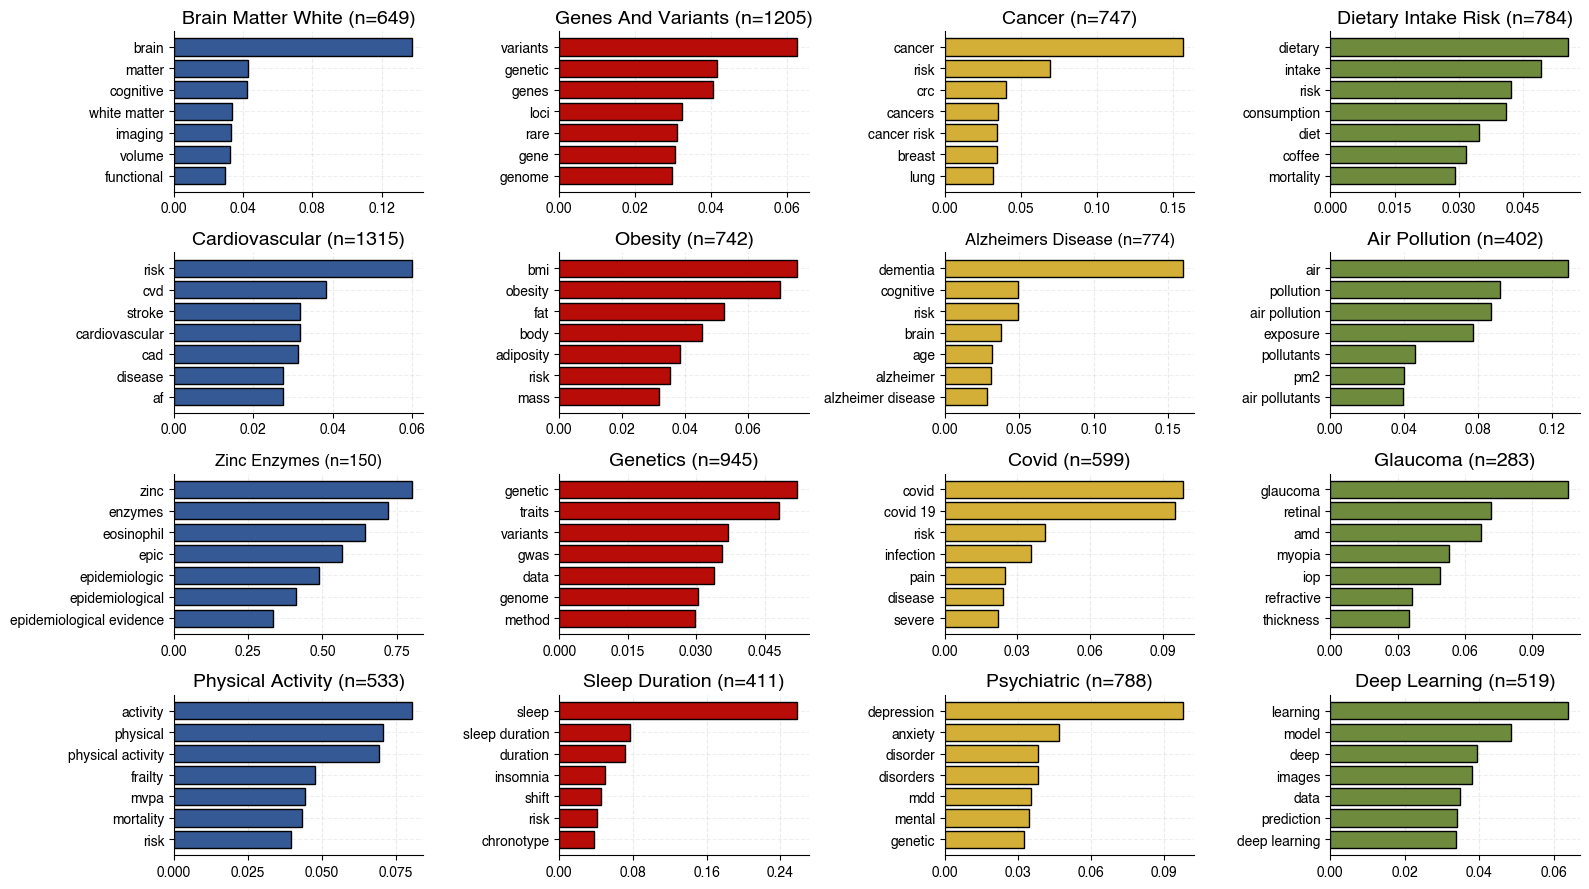

In [12]:
# ==============================================================
# CELL 2 — LOAD + PLOT TOPICS (PUBLICATION QUALITY)
# ==============================================================

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

plt.rcParams['font.family'] = 'Helvetica'

#sns.set_style("whitegrid")

MODELS_DIR = "../models"

print("=== LOADING MODELS ===")

embeddings = np.load(os.path.join(MODELS_DIR, "embeddings.npy"))
clusters = np.load(os.path.join(MODELS_DIR, "clusters.npy"))
topic_keywords = pickle.load(open(os.path.join(MODELS_DIR, "topic_keywords.pkl"), "rb"))
topic_weights = pickle.load(open(os.path.join(MODELS_DIR, "topic_weights.pkl"), "rb"))
topic_labels = pickle.load(open(os.path.join(MODELS_DIR, "topic_labels.pkl"), "rb"))
best_k = pickle.load(open(os.path.join(MODELS_DIR, "best_k.pkl"), "rb"))

print(f"Loaded {best_k} topics.")


# ==============================================================
# 1. PREP — CLEAN & PREP KEYWORDS, COMPUTE GLOBAL RANGE
# ==============================================================

# Remove duplicate stems (rudimentary but effective)
def dedupe_words(words):
    seen = set()
    cleaned = []
    for w in words:
        base = w.lower().strip()
        if base not in seen:
            cleaned.append(w)
            seen.add(base)
    return cleaned

# Clean panels & compute global max for uniform scaling
all_weights = []
cleaned_keywords = {}
cleaned_weights = {}

for t in range(best_k):
    kws = dedupe_words(topic_keywords[t])[:10]
    wts = topic_weights[t][:len(kws)]

    # Handle empty panels
    if len(wts) == 0 or np.allclose(wts, 0):
        # artificial nonzero weight pattern preventing blank panel
        wts = np.linspace(0.8, 0.1, len(kws))

    cleaned_keywords[t] = kws
    cleaned_weights[t] = wts
    all_weights.extend(wts)

global_max = max(all_weights) * 1.05


# Compute topic sizes
topic_sizes = {
    t: int(np.sum(clusters == t))
    for t in range(best_k)
}


# ==============================================================
# 2. FIGURE LAYOUT
# ==============================================================

regal_colors = ["#345995", "#B80C09", "#D4AF37", "#6E8B3D"]

cols = 4
rows = int(np.ceil(best_k / cols))
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
axes = axes.flatten()


# ==============================================================
# 3. PLOTTING LOOP
# ==============================================================

for t in range(best_k):
    ax = axes[t]

    words = cleaned_keywords[t][:7]
    weights = cleaned_weights[t][:7]

    # Reverse so highest weight appears at top
    words = words[::-1]
    weights = weights[::-1]

    color = regal_colors[t % len(regal_colors)]

    # --- GRIDLINES FIRST (drawn at low z-order) ---
    ax.xaxis.grid(True, linestyle="--", alpha=0.25, zorder=0)
    ax.yaxis.grid(True, linestyle="--", alpha=0.20, zorder=0)

    # --- BARS ABOVE GRID ---
    ax.barh(
        words,
        weights,
        color=color,
        edgecolor="k",
        height=0.8,
        zorder=3     # ensures bars are in front of gridlines
    )

    # Title with topic size
    ax.set_title(f"{topic_labels[t]} (n={topic_sizes[t]})",
                 fontsize=14, pad=6)

    # X-axis ticks
    ax.xaxis.set_major_locator(MaxNLocator(4))

    # Tweak y tick labels
    ax.tick_params(axis='y', labelsize=10)



# Hide unused subplot boxes
for j in range(best_k, rows * cols):
    axes[j].axis("off")

plt.subplots_adjust(hspace=0.38, wspace=0.25)
sns.despine()

axes[8].set_title('Zinc Enzymes (n=150)', fontsize=12)
axes[6].set_title('Alzheimers Disease (n=774)', fontsize=12)

plt.tight_layout()

print("=== CELL 2 COMPLETE ===")

plt.savefig("../output/figures/sbert.pdf", bbox_inches='tight')
plt.savefig("../output/figures/sbert.svg", bbox_inches='tight')
plt.savefig("../output/figures/sbert.png", bbox_inches='tight', dpi=800)